In [1]:
from SVDModel import SVDModel
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import pickle
import os.path
from pathlib import Path

np.random.seed(3362)

In [2]:
# Parameters
PARAM = dict()
PARAM['path'] = {
  'ml':'./data/MovieLens25M/',
  'netflix':'./data/NetflixPrize/'
}

PARAM

{'path': {'ml': './data/MovieLens25M/', 'netflix': './data/NetflixPrize/'}}

In [ ]:
# ML_25M = {
#   'ratings': pd.read_csv(PARAM['path']['ml']+'ratings.csv', dtype={
#     'userId': np.int32,
#     'movieId': np.int32,
# #     'rating': np.float64,
#     'timestamp':np.float64}).sample(2**16),
#   'movies': pd.read_csv(PARAM['path']['ml']+'movies.csv', dtype= {
#     'movieId':np.int32,
#     'title': str,
#     'genres': str
#   })
# }
# ML_25M['m_movies'] = ML_25M['movies']['movieId'].nunique()
# ML_25M['n_users'] = ML_25M['ratings']['userId'].nunique()
# ML_25M['n_ratings'] = len(ML_25M['ratings'])


# ML_25M['movies'].insert(1, 'newMovieId', value=range(1,len(ML_25M['movies'])+1))
# newMovieIdDict = {}
# for index, movie in ML_25M['movies'].iterrows():
#     newMovieIdDict[movie['movieId']] = movie['newMovieId']
# ML_25M['ratings'].replace({"movieId": newMovieIdDict}, inplace=True)
# ML_25M['ratings']['rating'] = ML_25M['ratings']['rating'].astype(np.float16)

# ML_25M

In [ ]:
# print(ML_25M['ratings'].size)
# print(ML_25M['movies'].size)

In [3]:
names = ['userId','rating','timestamp','movieId']
df_netflix = pd.read_csv(PARAM['path']['netflix']+'data_1.txt', names=names, low_memory=False)
df_netflix_2 = pd.read_csv(PARAM['path']['netflix']+'data_2.txt', names=names, low_memory=False)
df_netflix_3 = pd.read_csv(PARAM['path']['netflix']+'data_3.txt', names=names, low_memory=False)
df_netflix_4 = pd.read_csv(PARAM['path']['netflix']+'data_4.txt', names=names, low_memory=False)
df_netflix = pd.concat([df_netflix,df_netflix_2,df_netflix_3,df_netflix_4], names=names)
df_netflix['movieId'] = df_netflix['movieId'].fillna(method='ffill')
df_netflix.dropna(inplace=True)
df_netflix['rating'] = df_netflix['rating'].astype(np.int8)
df_netflix['movieId'] = df_netflix['movieId'].astype(np.int16)
df_netflix['userId'] = df_netflix['userId'].astype(np.int32)
df_netflix['timestamp'] = pd.to_datetime(df_netflix['timestamp']).view(dtype=np.int64) // 10 ** 9
df_movies = pd.read_csv(PARAM['path']['netflix']+'movie_titles.csv',
                        encoding='latin-1',
                        names=['movieId','release_year','title'],
                        usecols=range(3))
NETFLIX = {
  'ratings': df_netflix[['userId','movieId','rating','timestamp']].sample(2**12),
  'movies': df_movies,
  'm_movies': df_netflix['movieId'].nunique(),
  'n_users': df_netflix['userId'].nunique(),
  'n_ratings': len(df_netflix)
}


In [ ]:
'''
262144
53310
'''
print(NETFLIX['ratings'].shape)
print(NETFLIX['movies'].shape)

In [25]:
PARAM['features'] = [3,5,10,100,200,300]
PARAM['lr'] = [1e-2,1e-3,1e-4,1e-5]
PARAM['epochs'] = [11,101,201,301,501,1001]
PARAM['weight_decay'] = 0.02
PARAM['stopping'] = 0.001

def train_model(features, lr, epochs, data):
    print(f"==============================")
    print(f'features: {features}\nlearning rate: {lr}\nEpochs: {epochs}\nweight decay: 0.02\nstopping: 0.001')
    if os.path.isfile(f'./model_netflix/svd_{features}_{lr}_{epochs}_0.02_0.001.pkl'):
        with open(f'./model_netflix/svd_{features}_{lr}_{epochs}_0.02_0.001.pkl', 'rb') as inp:
            loaded_svd = pickle.load(inp)
            print('Found existing model loaded it')
        with open(f'./model_netflix/result_{features}_{lr}_{epochs}_0.02_0.001.pkl', 'rb') as inp:
            loaded_result = pickle.load(inp)
            print('Found existing result loaded it')
        return loaded_svd, loaded_result
    print('Creating SVD Model')
    svd = SVDModel(
        features=features, 
        lr=lr, 
        epochs=epochs, 
        weight_decay=PARAM['weight_decay'], 
        stopping=PARAM['stopping']
    )
    print("Created\nLoading Data")
    if data=='ML_25M':
        svd.data_loader(data=ML_25M['ratings'], 
                        n_items = ML_25M['m_movies'], 
                        n_users= ML_25M['n_users'])
    else:
        svd.data_loader(data=NETFLIX['ratings'], 
                        n_items = NETFLIX['m_movies'], 
                        n_users= NETFLIX['n_users'])
    print("Loaded Data\nSpliting Data")
    svd.split(0.6,0.8)
    print("Splitted Data\nTraining...")
    start = time.perf_counter()
    result = svd.training()
    print('Time used =', time.perf_counter()-start)
    
    print('Saving Model')
    svd.data = []
    Path("./model_netflix").mkdir(parents=True, exist_ok=True)
    
    with open(f'./model_netflix/svd_{features}_{lr}_{epochs}_0.02_0.001.pkl', 'wb') as out:
        pickle.dump(svd, out, pickle.HIGHEST_PROTOCOL)
    with open(f'./model_netflix/result_{features}_{lr}_{epochs}_0.02_0.001.pkl', 'wb') as out:
        pickle.dump(result, out, pickle.HIGHEST_PROTOCOL)
    print(f"==============================")
    return svd, results

In [26]:
svds = []
results = []
for epochs in PARAM['epochs']:
    for features in PARAM['features']:
        for lr in PARAM['lr']:
            for data in ['NETFLIX']:
                svd,result = train_model(features, lr, epochs, data)
                svds.append(svd)
                results.append(result)

features: 3
learning rate: 0.01
Epochs: 11
weight decay: 0.02
stopping: 0.001
Found existing model loaded it
Found existing result loaded it
features: 3
learning rate: 0.001
Epochs: 11
weight decay: 0.02
stopping: 0.001
Found existing model loaded it
Found existing result loaded it
features: 3
learning rate: 0.0001
Epochs: 11
weight decay: 0.02
stopping: 0.001
Creating SVD Model
Created
Loading Data
Loaded Data
Spliting Data
User Item Matrix Shape: (4039, 2140)
User Reference length: 4039
Item Reference length: 2140
Splitted Data
Training...


KeyboardInterrupt: 

# Graph
$$MSE=\frac{1}{N}\sum_{i=1}^N(predict_i-actual_i)^2$$
$$RMSE=\sqrt{\frac{\sum_{i=1}^N(predict_i-actual_i)^2}{N}}$$

14.263299724277744
3.7766783983121655


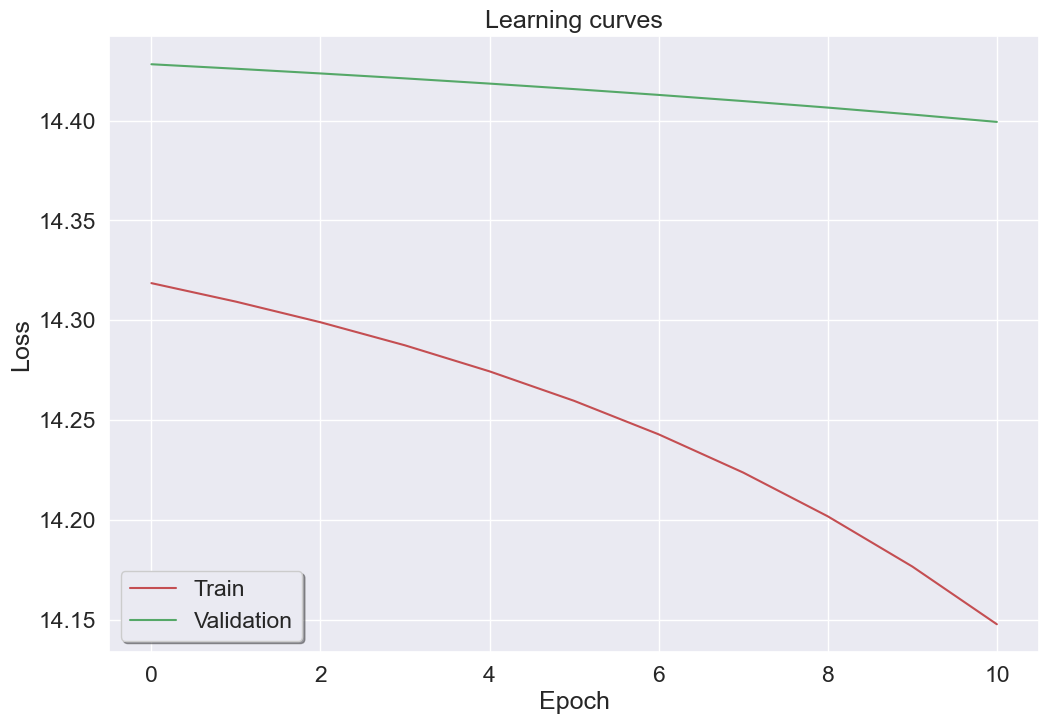

14.221169586985448
3.7710966027119284


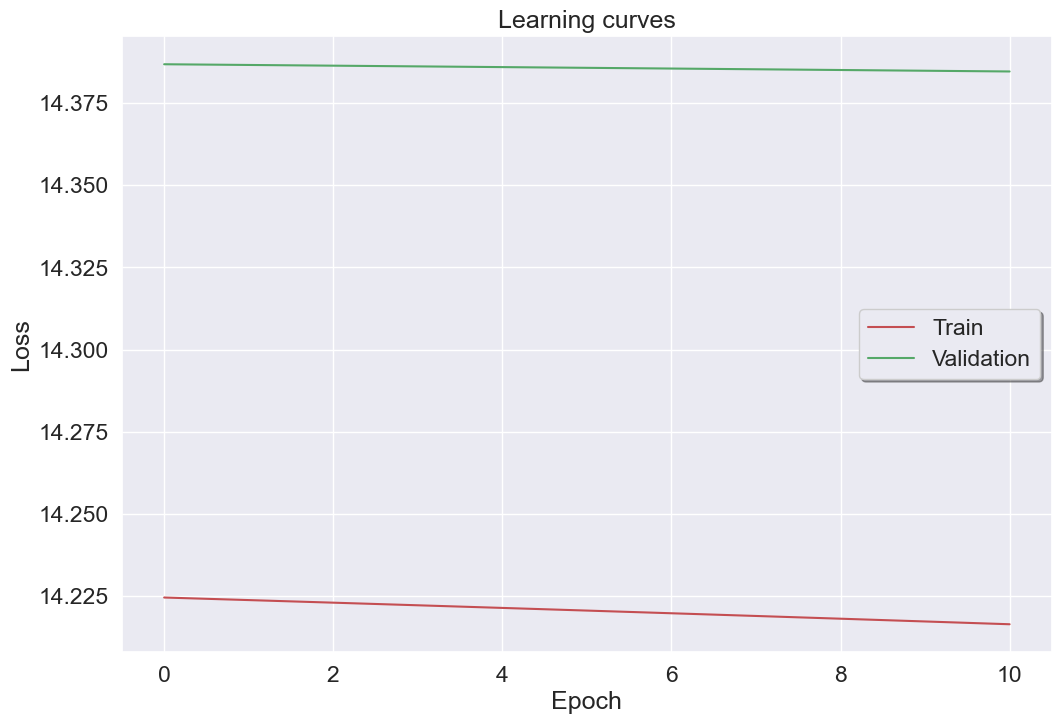

In [39]:
for r in results:
    x = list(range(len(r[0])))
    k=0

#     sns.set(rc={'figure.figsize':(12,8)})
#     sns.set(font_scale = 1.5)
    print('MSE')
    print(sum(np.array(r[2])**2/len(r[2])))
    print('RMSE')
    print(np.sqrt(sum(np.array(r[2])**2/len(r[2]))))

    plt.plot(x[-k:], r[0][-k:], 'r', label="Train")
    plt.plot(x[-k:], r[1][-k:], 'g', label="Validation")
    plt.title('Learning curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    leg = plt.legend(loc='best', shadow=True, fancybox=True)
    plt.show()